In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import librosa
import os
import soundfile as sf
import tarfile
import shutil
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2023-07-14 23:14:27.117066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 ## Data preprocessing
 The tar file is extracted and then new _background_noise_ audios are generated in desired length with using sliding window approach. To avoid information loss, in each frame, apply a window function (Hann, Hamming, Blackman etc) - to minimize discontinuities at the beginning and end (overlapping by the half size of the files)

In [3]:
cwd = os. getcwd()
DATASET_PATH = cwd + '/speech_commands_v0.02'
data_dir = pathlib.Path(DATASET_PATH)

if data_dir.exists():
    shutil.rmtree(DATASET_PATH, ignore_errors=True)
    tar_path = '/Users/elnur/Desktop/HDA/project/speech_commands_v0.02.tar'
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(DATASET_PATH)
    print("preprocessed data is removed and original data is extracted")
else:
    tar_path = '/Users/elnur/Desktop/HDA/project/speech_commands_v0.02.tar'
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(DATASET_PATH)
    print("data is extracted")
 

data is extracted


In [ ]:
def split_background_noise_files(folder_path, duration):
    # Get a list of all audio files in the folder
    audio_files = [file for file in os.listdir(folder_path) if file.endswith(".wav")]

    # Iterate over the audio files
    for audio_file in audio_files:
        # Construct the full path of the audio file
        audio_path = os.path.join(folder_path, audio_file)

        # Load the background noise segment
        audio, sr = librosa.load(audio_path, sr=None)

        # Calculate the number of samples in the desired duration
        desired_samples = int(sr * duration)

        # Calculate the step size for sliding the window
        hop_length = desired_samples // 2

        # Slide the window over the background noise segment
        for i in range(0, len(audio) - desired_samples + 1, hop_length):
            # Extract the chunk within the current window
            chunk = audio[i:i + desired_samples]
            # Apply window function to the chunk(hanning)
            windowed_chunk = chunk * np.hanning(len(chunk))
            # windowed_chunk = chunk * np.blackman(len(chunk))
            # Construct the output file name
            output_file = audio_file.replace(".wav", f"_chunk{i}.wav")

            # Construct the full output file path
            output_path = os.path.join(folder_path, output_file)

            # Save the chunk as a separate audio file
            sf.write(output_path, windowed_chunk, sr)

        os.remove(audio_path)
# Example usage
folder_path = '/Users/elnur/Desktop/HDA/project/speech_commands_v0.02/_background_noise_'
duration = 1.0  # Desired duration of each segmented chunk in seconds

# Split each audio file in the folder into smaller chunks
split_background_noise_files(folder_path, duration)


In [4]:
cwd = os. getcwd()
DATASET_PATH = cwd + '/speech_commands_v0.02'
data_dir = pathlib.Path(DATASET_PATH)


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.
Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2023-07-14 23:15:38.019229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 23:15:38.027119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-14 23:15:38.029005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 23:15:38.029365: I tensorflow/core/common_runtime/pluggable_device/plug


label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(2):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)
(64, 16000)
(64,)


In [11]:
label_names[[1,1,3,0]]

array(['backward', 'backward', 'bird', '_background_noise_'], dtype='<U18')

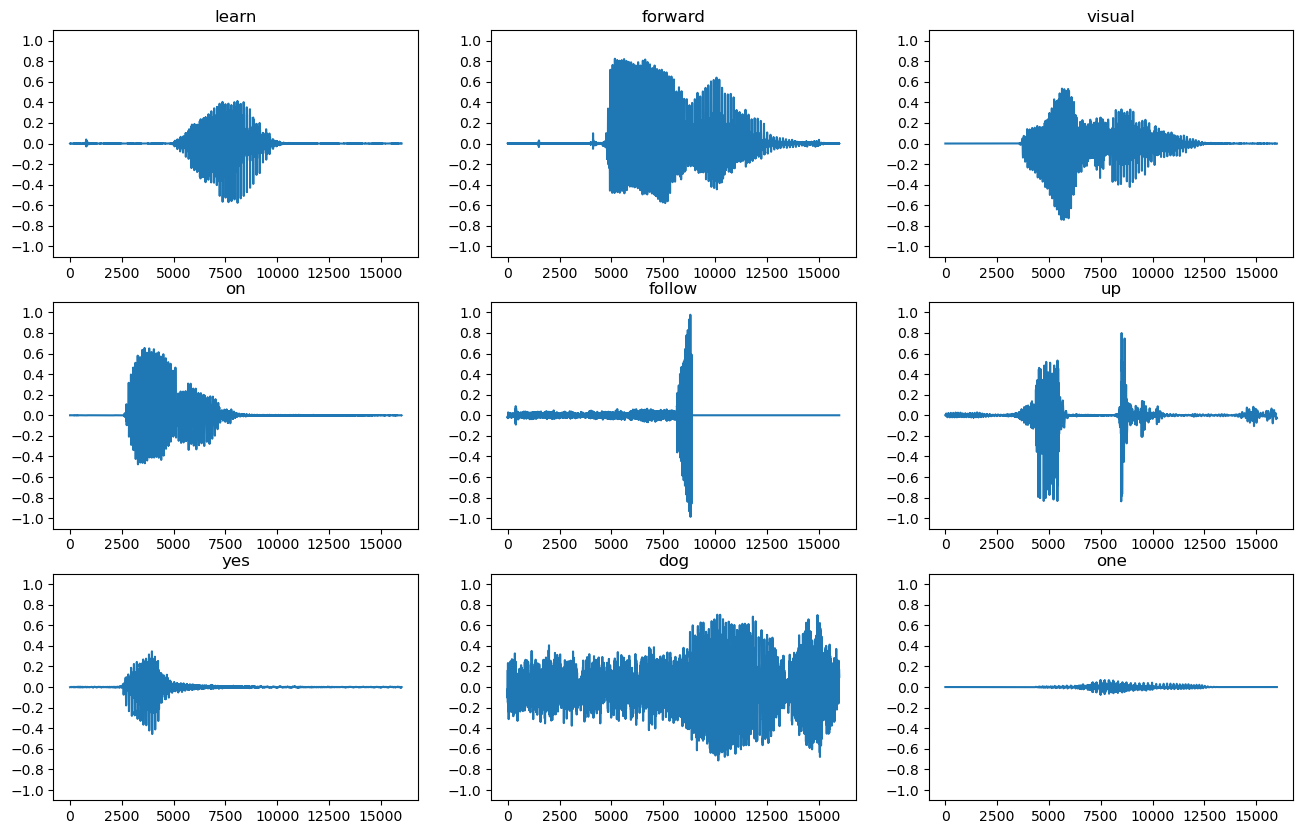

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: learn
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: forward
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: visual
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

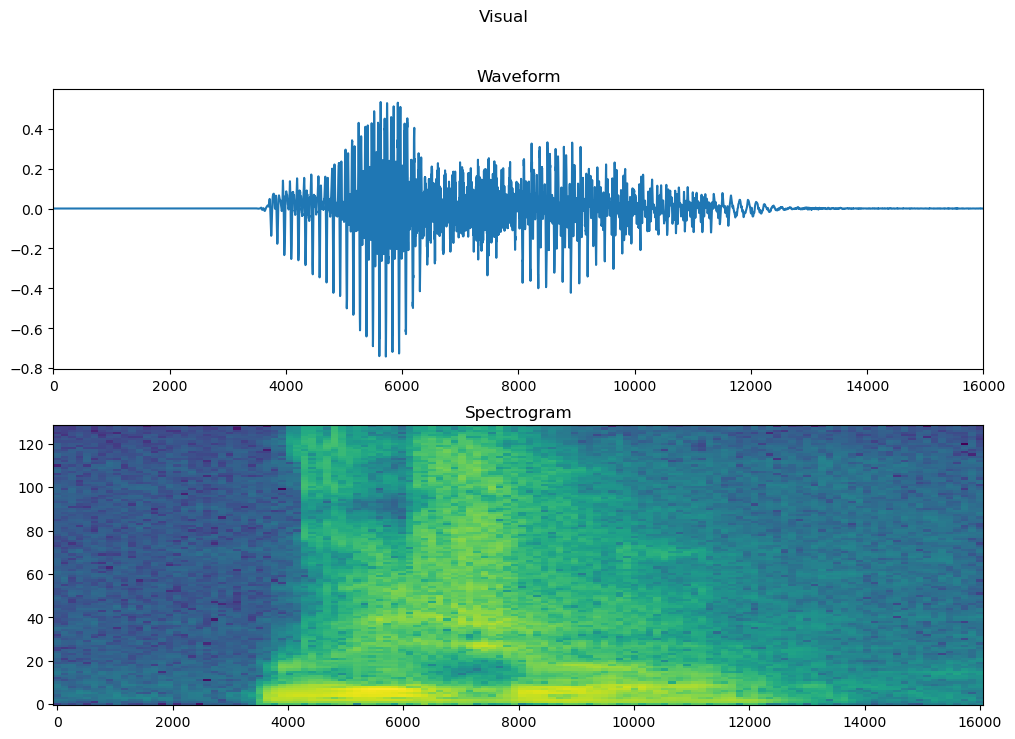

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Print spectogram of background noise

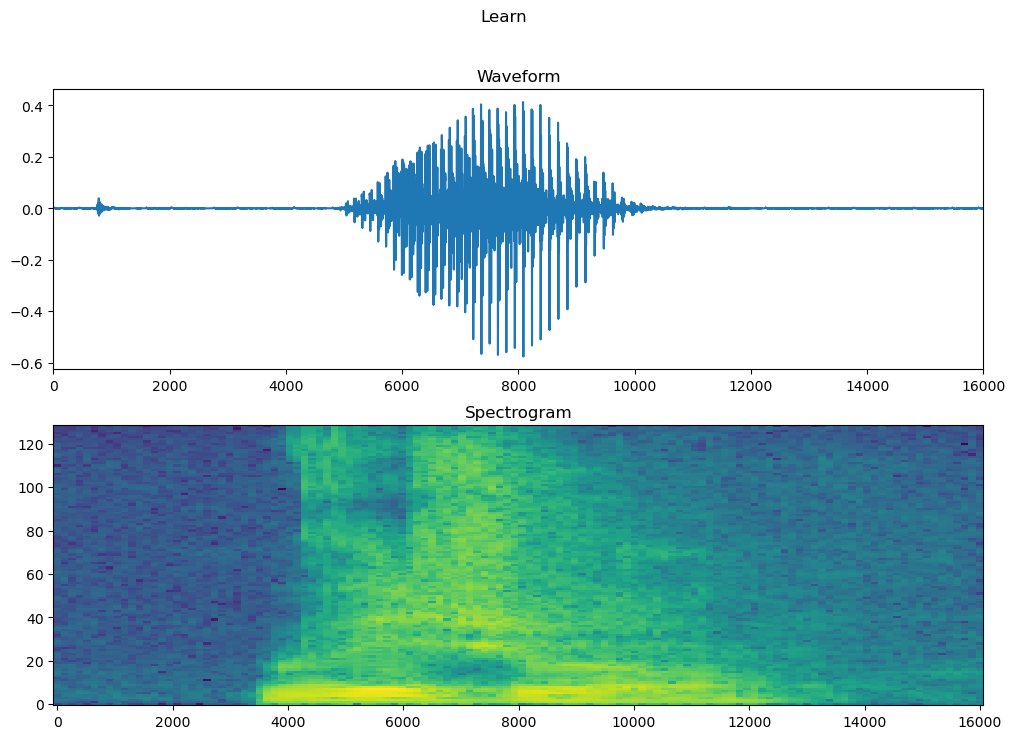

In [17]:
label = label_names[example_labels[0]]
waveform = example_audio[0]
spectrogram_of_background_noise = get_spectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [18]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [20]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

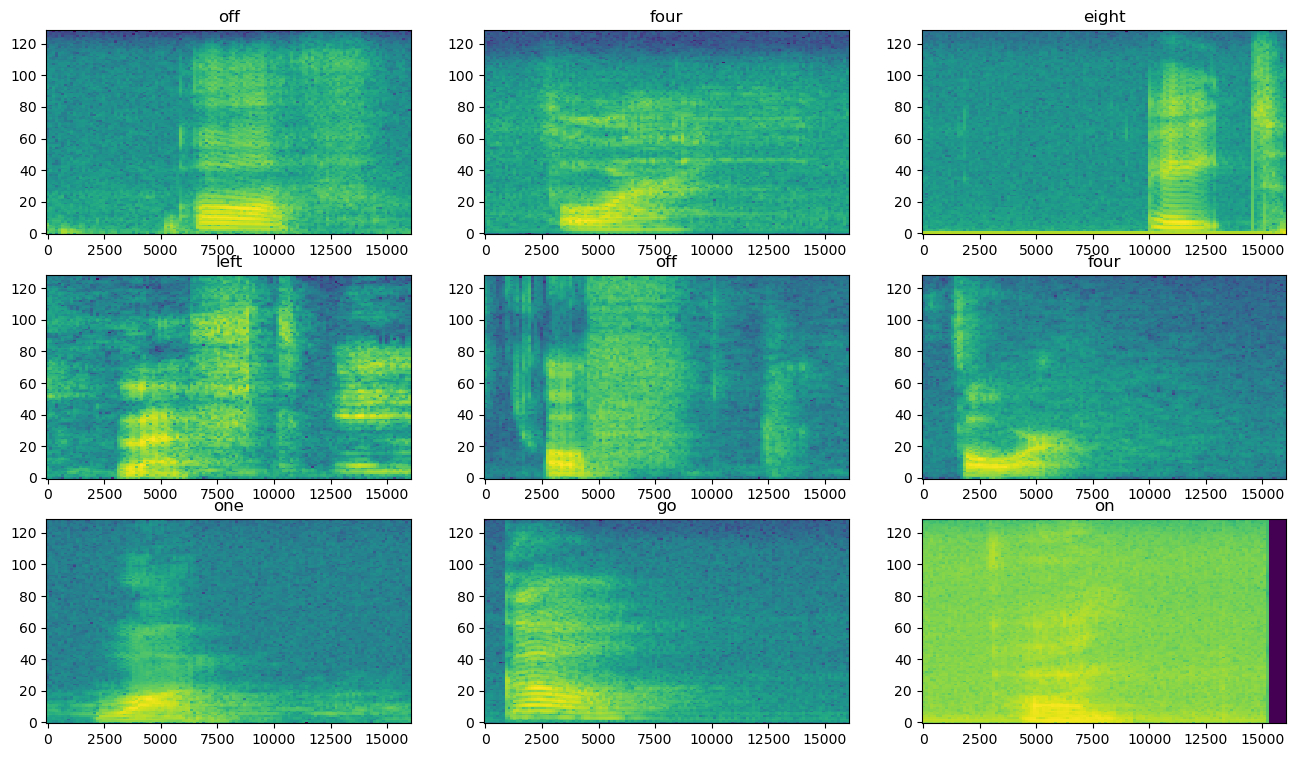

In [21]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [22]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [23]:
devices = tf.config.list_physical_devices()
print(devices)
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


2023-07-14 23:15:59.306201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-14 23:15:59.306237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
tf.debugging.set_log_device_placement(True)

In [28]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2023-07-14 23:17:29.439036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-14 23:17:29.477670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-14 23:17:39.502376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 470 of 10000
2023-07-14 23:17:49.566668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 877 of 10000
2023-07-14 23:17:59.517314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1253 of 10000
2023-07-14 23:18:01.954717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2023-07-11 19:43:52.069672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1322/1323 [============================>.] - ETA: 0s - loss: 1.9167 - accuracy: 0.4600

2023-07-11 19:44:51.327526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1323/1323 [==============================] - 68s 49ms/step - loss: 1.9162 - accuracy: 0.4601 - val_loss: 1.0056 - val_accuracy: 0.7067
Epoch 2/10
1323/1323 [==============================] - 65s 49ms/step - loss: 0.9831 - accuracy: 0.7078 - val_loss: 0.8253 - val_accuracy: 0.7631
Epoch 3/10
1323/1323 [==============================] - 59s 45ms/step - loss: 0.6775 - accuracy: 0.7938 - val_loss: 0.7426 - val_accuracy: 0.7822
Epoch 4/10
1323/1323 [==============================] - 59s 45ms/step - loss: 0.4887 - accuracy: 0.8480 - val_loss: 0.7415 - val_accuracy: 0.7958
Epoch 5/10
1323/1323 [==============================] - 65s 49ms/step - loss: 0.3550 - accuracy: 0.8886 - val_loss: 0.7997 - val_accuracy: 0.7934
Epoch 6/10
1323/1323 [==============================] - 58s 44ms/step - loss: 0.2717 - accuracy: 0.9148 - val_loss: 0.8657 - val_accuracy: 0.7922
Epoch 6: early stopping


Text(0, 0.5, 'Accuracy [%]')

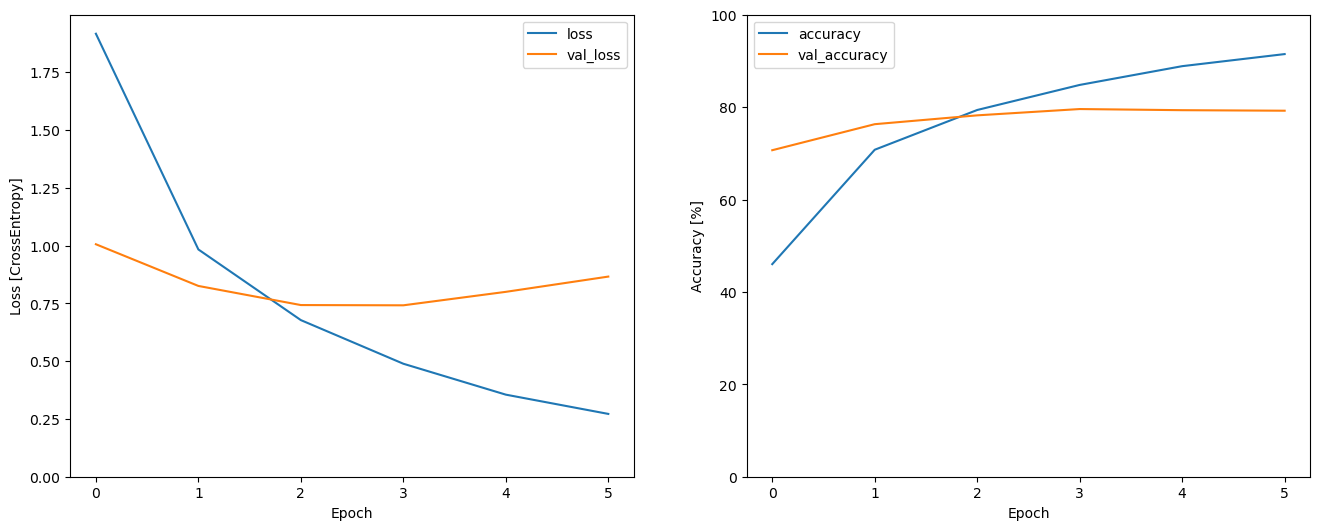

In [26]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate

In [27]:
model.evaluate(test_spectrogram_ds, return_dict=True)

166/166 [==============================] - 7s 41ms/step - loss: 0.8412 - accuracy: 0.8034


{'loss': 0.8412136435508728, 'accuracy': 0.8034316897392273}

## Display confusion matrix

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

166/166 [==============================] - 8s 47ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

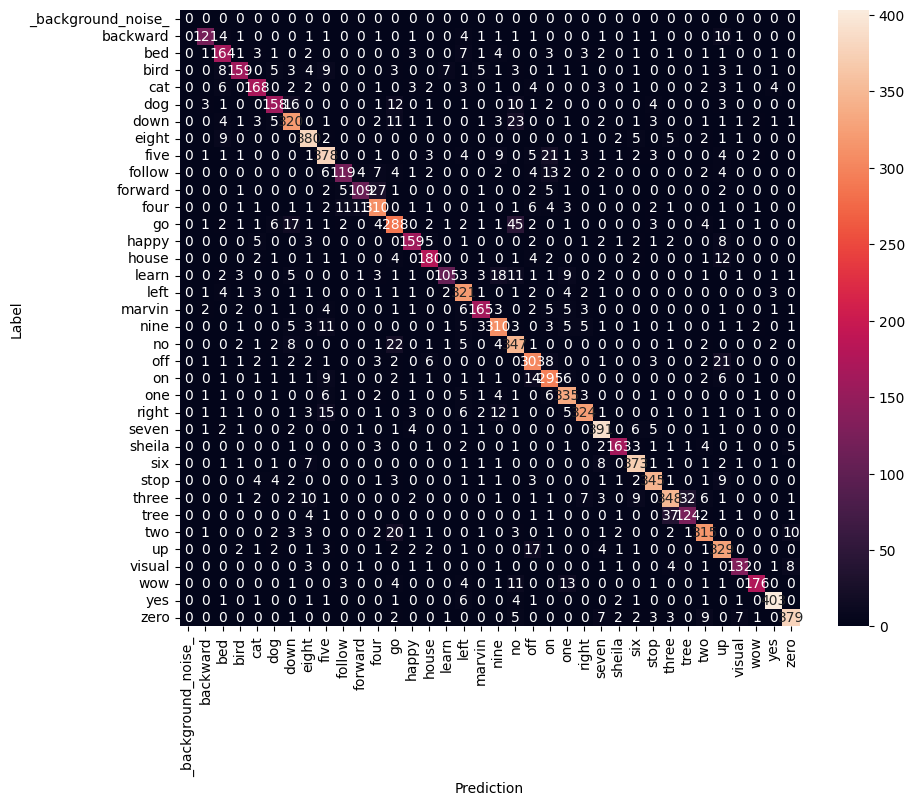

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()